In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats

In [2]:
# Loading the provided  data
labeled_data = pd.read_csv("/Users/yevrud/redi_school_ML_AI/final_project/data/train.csv")

unlabeled_data = pd.read_csv("/Users/yevrud/redi_school_ML_AI/final_project/data/test.csv")


In [3]:
# Creating a copy of the data for processing
df_train = labeled_data.copy()
df_test = unlabeled_data.copy()

In [4]:
confidential_cols = ['name', 'email', 'phone-number', 'credit_card', 'id']
df_train.drop(columns=confidential_cols, inplace=True)


In [5]:
X = df_train.drop(columns=['is_canceled'])
y = df_train['is_canceled']

In [6]:
# Identifying numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [7]:
# Exploring correlations for numerical features
correlation_matrix = df_train[numerical_features + ['is_canceled']].corr()

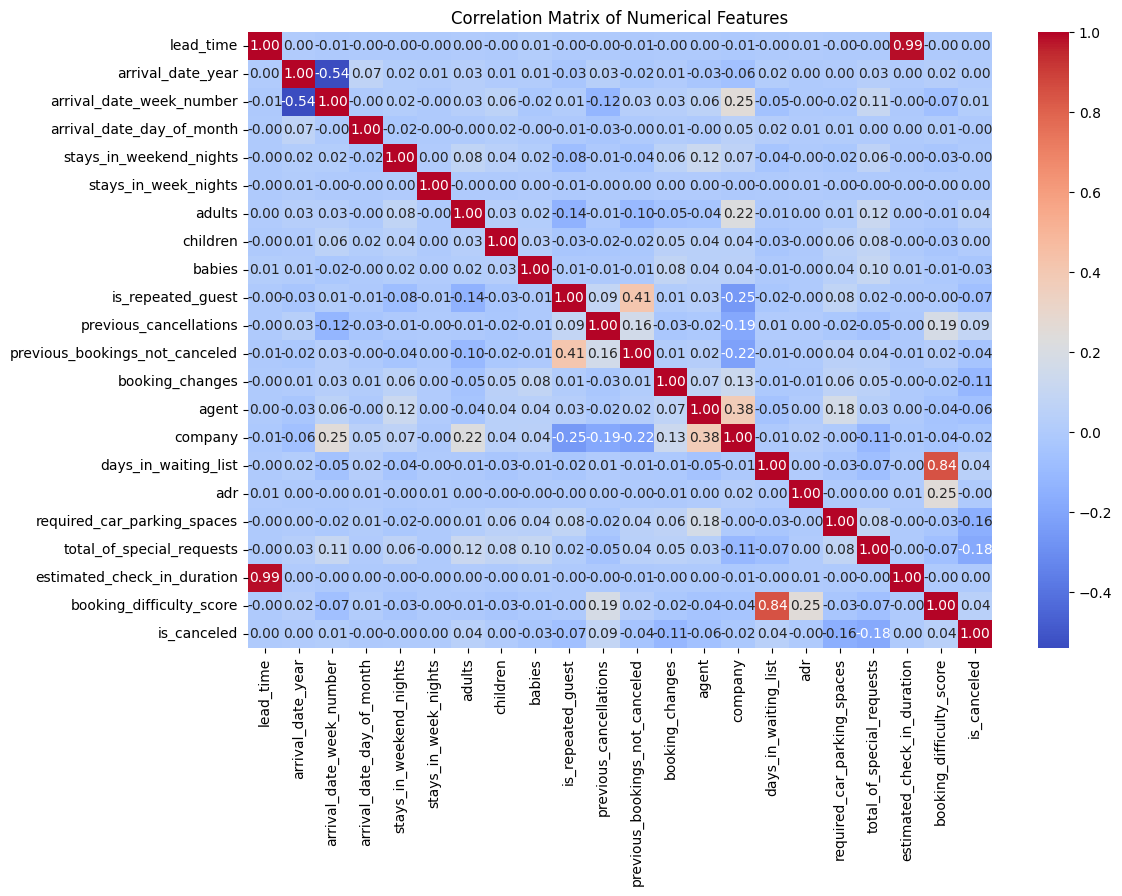

In [8]:
# Plotting the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [9]:
# Preprocessing pipelines
# For numerical features: impute missing values with median
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


# For categorical features: impute missing values with 'most_frequent' and one-hot encode
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [10]:
# Combine preprocessing for both feature types
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features),
    ])


In [11]:
# Check class balance after outlier removal
print("Class distribution after cleaning:")
print(df_train['is_canceled'].value_counts())


Class distribution after cleaning:
is_canceled
0    50377
1    33196
Name: count, dtype: int64


In [12]:
# Applying preprocessing to the dataset
X_preprocessed = preprocessor.fit_transform(X)

In [13]:
X_train, X_temp, y_train, y_temp = train_test_split(X_preprocessed, y, test_size=0.4, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)



In [14]:
# Initializing and training the logistic regression model
logreg = LogisticRegression(max_iter=2000, solver='lbfgs', random_state=42)
logreg.fit(X_train, y_train)

# Making predictions on the test set
y_pred = logreg.predict(X_test)

# Evaluating the model
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

In [15]:
# Printing results
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

F1 Score: 0.8739730274376065
Confusion Matrix:
[[9451  625]
 [1001 5638]]


**Predict on unlabeled test data and save predictions**


In [16]:
# Keep a copy of the ID column before dropping confidential columns
ids = unlabeled_data['id']

# Drop confidential columns (same as for training)
df_test.drop(columns=confidential_cols, inplace=True)

# Select features
X_unlabeled = df_test

# Apply the same preprocessing (use transform, not fit_transform)
X_unlabeled_preprocessed = preprocessor.transform(X_unlabeled)

# Predict labels
y_unlabeled_pred = logreg.predict(X_unlabeled_preprocessed)

# Create a DataFrame with id and prediction
output = pd.DataFrame({
    "id": ids,
    "is_canceled": y_unlabeled_pred
})

# Save to CSV
output.to_csv("unlabeled_predictions.csv", index=False)
print("Predictions saved to 'unlabeled_predictions.csv'")

Predictions saved to 'unlabeled_predictions.csv'
